In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from se3_cnn import basis_kernels
from se3_cnn import SO3
from lie_learn.representations.SO3.wigner_d import wigner_D_matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Sample basis

In [8]:
size = 7
n_radial = size//2+1 # hard coded
upsampling = 1 # hard coded

reps = [SO3.repr1, SO3.repr3, SO3.repr5, SO3.repr7, SO3.repr9, SO3.repr11]
order_in = 1
order_out = 0
R_in = reps[order_in]
R_out = reps[order_out]

basis = basis_kernels.cube_basis_kernels_analytical(size, n_radial, upsampling, R_out, R_in)

print('basis of shape', basis.shape)

basis of shape (3, 1, 3, 7, 7, 7)


Check basis equivariance. For better results adapt radial bandlimits and shell thickness.
If the equivariance drops in the last equivariance values it is likely that the outer shell ranges too far out of the kernel.

[ 0.98748742  0.95806136  0.73254993]


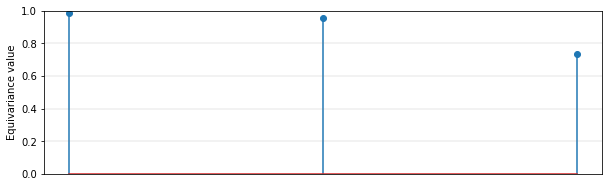

In [9]:
avg_equiv = np.zeros(len(basis))
N_samples = 25
for a,b,c in 2*np.pi*np.random.rand(N_samples,3):
    avg_equiv += basis_kernels.check_basis_equivariance(basis, R_out, R_in, a,b,c)
avg_equiv /= N_samples

print(avg_equiv)
plt.figure(figsize=(10,3))
plt.stem(avg_equiv)
for y in np.arange(.2,1,.2):
    plt.axhline(y, lw=.2, c='gray')
plt.ylim([0, 1])
plt.ylabel('Equivariance value')
plt.tick_params(axis='x', bottom='off', labelbottom='off')
plt.show()

Plot all basis elements. Each row corresponds to the z-slices of one kernel in/out channel.

In [ ]:
def plot_cube(cube):
    ''' plot view aligned with z-axis (z-slices) '''
    vmin, vmax = cube.min(), cube.max()
    size = cube.shape[-1]
    plt.figure(figsize=(1.5*size, 1.5))
    for idx_z in range(size):
        plt.subplot(1, 7, idx_z+1)
        plt.imshow(cube[:,:,idx_z], vmin=vmin, vmax=vmax)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

for idx_basis,b_elem in enumerate(basis):
    print('#################################################################')
    print('Basis element {}'.format(idx_basis))
    print('#################################################################')
    for m,out_ch in zip(np.arange(-order_out, order_out+1), b_elem):
        print('\nout channel m = {}'.format(m))
        for n,in_ch in zip(np.arange(-order_in, order_in+1), out_ch):
            print('in channel n = {}'.format(n))
            plot_cube(in_ch)

In [ ]:
def steer_basis_elem(basis_elem, order_in, order_out, alpha, beta, gamma):
    ''' rotate basis element by steering it via the tensor representation '''
    R_in  = reps[order_in](alpha, beta, gamma)
    R_out = reps[order_out](alpha, beta, gamma)
    return np.einsum('mn,no...,op->mp...', R_out, basis_elem, R_in.T)

def rotate_basis_elem(basis_elem, alpha, beta, gamma):
    ''' rotate basis element via bicubic interpolation '''
    from se3_cnn import SO3
    from scipy.ndimage import affine_transform

    n = basis.shape[0]
    dim_in = SO3.dim(R_in)
    dim_out = SO3.dim(R_out)
    size = basis.shape[-1]

    x = basis.reshape((-1, size, size, size))
    y = np.empty_like(x)

    rot = SO3.rot(alpha, beta, gamma)
    center = (np.array(x.shape[1:]) - 1) / 2

    for k in range(y.shape[0]):
        y[k] = affine_transform(x[k], matrix=rot, offset=center - np.dot(rot, center))

    return y.reshape(basis.shape)

Only for debugging
Assumes order_in=1, order_out=0. Then the kernels correspond to spherical harmonics Y^1.
Compares rotation by steering and by interpolation.

In [ ]:
alpha_d,beta_d,gamma_d = 20, 30, 0
alpha,beta,gamma = np.pi/180*np.array([alpha_d,beta_d,gamma_d])

b = basis[0]
bs = steer_basis_elem(b, order_in, order_out, alpha,beta,gamma)
br = rotate_basis_elem(basis, alpha,beta,gamma)[0]

print('non rotated')
for cube in b.squeeze():
    plot_cube(cube)
print('steered by alpha={}, beta={}, gamma={} degree'.format(alpha_d,beta_d,gamma_d))
for cube in bs.squeeze():
    plot_cube(cube)
print('rotated by alpha={}, beta={}, gamma={} degree'.format(alpha_d,beta_d,gamma_d))
for cube in br.squeeze():
    plot_cube(cube)

In [ ]:
basis_elem = b

from ipywidgets import interact, FloatSlider, RadioButtons

alpha_slider = FloatSlider(min=0, max=360, step=1, value=0)
beta_slider  = FloatSlider(min=0, max=180, step=1, value=0)
gamma_slider = FloatSlider(min=0, max=360, step=1, value=0)
# decorate the plot function with an environment from the UIs:
@interact(alpha=alpha_slider, beta=beta_slider, gamma=gamma_slider)
def steer_plot(alpha,beta,gamma):
    alpha *= np.pi/180
    beta  *= np.pi/180
    gamma *= np.pi/180
    steered = steer_basis_elem(basis_elem, order_in, order_out, alpha, beta, gamma)
    for cube in steered.squeeze():
        plot_cube(cube)